In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
!wandb login 9676e3cc95066e4865586082971f2653245f09b4

Appending key for api.wandb.ai to your netrc file: /Users/guydavidson/.netrc
Successfully logged in to Weights & Biases!


In [377]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
from scipy.special import factorial

from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import patches
from matplotlib import path as mpath

import pickle
import tabulate
import wandb
import os

In [4]:
np.set_printoptions(linewidth=100)

In [253]:
MIN_FONT_SIZE = 14
LABELS_FONT_SIZE = 20
TITLE_FONT_SIZE = 24

matplotlib.rcParams.update({'font.size': MIN_FONT_SIZE})
FONT_DICT = dict(fontsize=LABELS_FONT_SIZE) 
TITLE_FONT_DICT = dict(fontsize=TITLE_FONT_SIZE)

PER_PLOT_WIDTH = 6

## Fetch the relevant runs from WandB

In [374]:
def save(save_path):
    if save_path is not None:
        folder, filename = os.path.split(save_path)
        os.makedirs(folder, exist_ok=True)
        plt.savefig(save_path)


In [373]:
FULL_DATASET_PATTERN = 'meta-learning-scaling/sequential-benchmark/{run_id}'
FULL_DATASET_RUN_IDS = ('xk3ic9p7', 'lgkb14dn', '43wf5c4j', 'qq4mewef', 'i8o9tns8')


api = wandb.Api()
histories = [api.run(FULL_DATASET_PATTERN.format(run_id=run_id)).history(pandas=True)
             for run_id in FULL_DATASET_RUN_IDS]


In [25]:
print(histories[0].shape)
histories[0][:10]

(141, 95)


,Test AUC,Test Accuracy,Test Loss,Test Per-Query Accuracy (dict).0,Test Per-Query Accuracy (dict).1,Test Per-Query Accuracy (dict).10,Test Per-Query Accuracy (dict).11,Test Per-Query Accuracy (dict).12,Test Per-Query Accuracy (dict).13,Test Per-Query Accuracy (dict).14,...,gradients/fc1.bias,gradients/fc1.weight,gradients/fcout.fc2.bias,gradients/fcout.fc2.weight,gradients/fcout.fc3.bias,gradients/fcout.fc3.weight,gradients/fcout.fc4.bias,gradients/fcout.fc4.weight,gradients/fcout.fc5.bias,gradients/fcout.fc5.weight
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"{'_type': 'histogram', 'values': [4, 0, 3, 2, ...","{'bins': [-0.0007078171474859118, -0.000686200...","{'bins': [-3.4073571441695094e-05, -3.06374058...","{'_type': 'histogram', 'values': [1, 0, 0, 0, ...","{'_type': 'histogram', 'values': [1, 0, 0, 0, ...","{'_type': 'histogram', 'values': [3, 1, 3, 0, ...","{'_type': 'histogram', 'values': [1, 0, 0, 0, ...","{'_type': 'histogram', 'values': [1, 1, 0, 1, ...","{'_type': 'histogram', 'values': [1, 0, 0, 0, ...","{'_type': 'histogram', 'values': [2, 1, 0, 0, ..."
1,0.516887,54.79,0.684010,0.5378,0.5654,0.4910,0.5188,0.4758,0.5030,0.5780,...,"{'_type': 'histogram', 'values': [1, 0, 0, 1, ...","{'bins': [-0.006817657500505447, -0.0066224099...","{'bins': [-0.0019140464719384909, -0.001858757...","{'_type': 'histogram', 'values': [1, 0, 0, 0, ...","{'values': [1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 2...","{'values': [1, 2, 1, 0, 2, 0, 1, 7, 9, 9, 16, ...","{'_type': 'histogram', 'values': [1, 2, 0, 0, ...","{'_type': 'histogram', 'values': [1, 3, 3, 2, ...","{'_type': 'histogram', 'values': [1, 0, 0, 0, ...","{'_type': 'histogram', 'values': [1, 0, 2, 1, ..."
2,0.518163,55.52,0.685925,0.5464,0.5624,0.5068,0.5408,0.4944,0.5010,0.5946,...,"{'bins': [-0.02490227483212948, -0.02411620505...","{'_type': 'histogram', 'values': [4, 3, 3, 2, ...","{'_type': 'histogram', 'values': [2, 1, 1, 1, ...","{'bins': [-0.036345042288303375, -0.0345625244...","{'values': [1, 1, 1, 4, 4, 2, 6, 0, 1, 0, 1, 2...","{'bins': [-0.008250974118709564, -0.0079305432...","{'_type': 'histogram', 'values': [3, 1, 5, 4, ...","{'_type': 'histogram', 'values': [1, 1, 3, 4, ...","{'bins': [-0.0384378507733345, -0.037236668169...","{'_type': 'histogram', 'values': [3, 1, 4, 8, ..."
3,0.571805,59.56,0.628058,0.5462,0.5568,0.5328,0.6620,0.5964,0.5796,0.5980,...,"{'values': [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0...","{'bins': [-0.03510168194770813, -0.03343043848...","{'_type': 'histogram', 'values': [2, 0, 0, 0, ...","{'_type': 'histogram', 'values': [2, 0, 0, 0, ...","{'_type': 'histogram', 'values': [1, 0, 0, 1, ...","{'_type': 'histogram', 'values': [1, 1, 0, 0, ...","{'_type': 'histogram', 'values': [1, 0, 0, 0, ...","{'_type': 'histogram', 'values': [1, 0, 0, 0, ...","{'_type': 'histogram', 'values': [1, 0, 0, 0, ...","{'_type': 'histogram', 'values': [4, 1, 3, 8, ..."
4,0.595458,61.67,0.597502,0.5510,0.5526,0.6360,0.6840,0.6100,0.5914,0.9514,...,"{'_type': 'histogram', 'values': [1, 0, 0, 0, ...","{'_type': 'histogram', 'values': [1, 0, 1, 0, ...","{'_type': 'histogram', 'values': [1, 2, 0, 0, ...","{'_type': 'histogram', 'values': [1, 0, 0, 0, ...","{'_type': 'histogram', 'values': [1, 2, 1, 1, ...","{'_type': 'histogram', 'values': [8, 0, 0, 0, ...","{'_type': 'histogram', 'values': [2, 0, 0, 1, ...","{'_type': 'histogram', 'values': [1, 0, 0, 1, ...","{'_type': 'histogram', 'values': [1, 0, 0, 0, ...","{'_type': 'histogram', 'values': [1, 0, 1, 2, ..."
5,0.635470,64.14,0.559530,0.5428,0.5494,0.9172,0.6850,0.6392,0.5960,0.9806,...,"{'_type': 'histogram', 'values': [1, 0, 0, 1, ...","{'values': [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1...","{'_type': 'histogram', 'values': [1, 0, 0, 0, ...","{'_type': 'histogram', 'values': [2, 0, 1, 1, ...","{'_type': 'histogram', 'values': [1, 0, 0, 0, ...","{'_type': 'histogram', 'values': [1, 1, 3, 2, ...","{'bins': [-0.020014390349388123, -0.0194889325...","{'bins': [-0.00407235324382782, -0.00396479154...","{'_type': 'histogram

## Old benchmark iterations behavior

In [378]:
def old_benchmark_iteration_plot(benchmark_histories, key_format, query_orders, super_title, ylims=None,
                               x_start=0, compute_x_max=False, font_dict=None, title_font_dict=None, save_path=None):
    if ylims is None:
        ylims = [None] * len(benchmark_histories)
    
    if font_dict is None:
        font_dict = {}
    
    if title_font_dict is None:
        title_font_dict = font_dict.copy()
    
    
    plt.figure(figsize=((PER_PLOT_WIDTH + 2) * len(benchmark_histories), 6))
    plt.subplots_adjust(top=0.9, hspace=0.25, wspace=0.2)
    plt.suptitle(super_title, fontsize=font_dict['fontsize'] * 1.5)
        
    x_max = None
    if compute_x_max:
        x_max = np.min([len(history[key_format.format(q=0)]) for history in model_histories])
    
    for model_index, (history, query_order) in enumerate(zip(benchmark_histories, query_orders)):
        ax = plt.subplot(1, len(benchmark_histories), model_index + 1)
        
        handles = []
    
        for i, q in enumerate(query_order):
            key = key_format.format(q=q)
            y_values = history[key][x_start:x_max] * 100
            x_values = np.arange(len(y_values)) + x_start + 1
            
            handles.extend(ax.plot(x_values, y_values, label=f'Query #{i + 1}'))
            
        if ylim is not None:
            ax.set_ylim(ylim)

        legend_font_dict = font_dict.copy()
        legend_font_dict['fontsize'] = legend_font_dict['fontsize'] - 8
        
        # Create a legend for the first half of the queryies
        first_legend = plt.legend(handles=handles[:5], loc='lower left', **legend_font_dict)

        # Add the legend manually to the current Axes.
        ax.add_artist(first_legend)

        # Create another legend for the second half of the queries
        plt.legend(handles=handles[5:], loc='lower right', **legend_font_dict)
        
        
        ax.set_xlabel('Epoch', **font_dict)
        ax.set_ylabel('Test accuracy', **font_dict)
#         ax.set_title(**title_font_dict)
    
    save(save_path)
    plt.show()
        

In [315]:
old_bechmark_histories = [api.run(FULL_DATASET_PATTERN.format(run_id=run_id)).history(pandas=True) 
                          for run_id in ('71v9mgax', '61np1dca')]

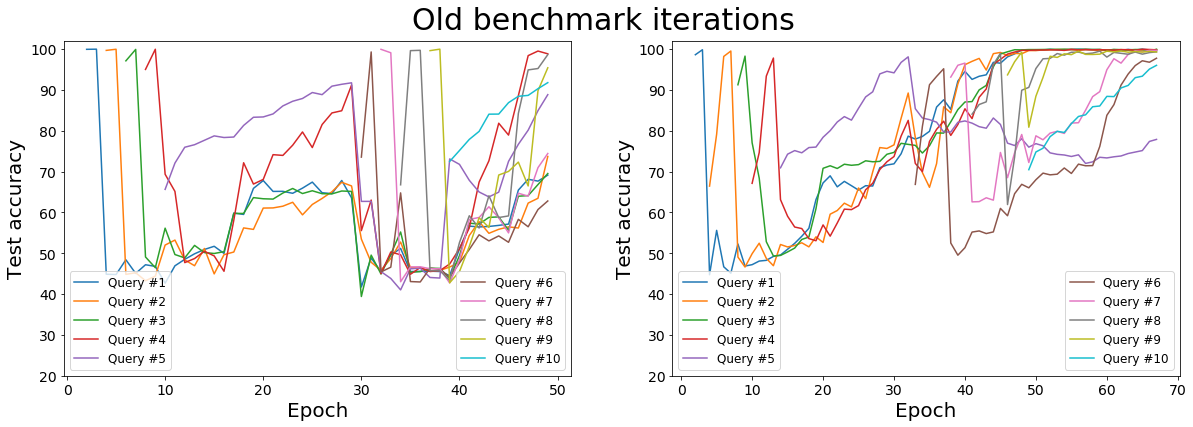

In [379]:
ylim = (20, 102)

old_benchmark_iteration_plot(old_bechmark_histories, 'Test accuracy, query = {q}', 
                             ([2, 8, 4, 9, 1, 6, 7, 3, 0, 5], [2, 8, 4, 9, 1, 6, 7, 3, 0, 5]), 'Old benchmark iterations',
                            font_dict=FONT_DICT, ylims=ylim, save_path='meta_learning/figures/benchmark/old_benchmark.png')

# Recreate some default WandB plots but with my formatting

In [380]:
DEFAULT_PAIRED_COLORMAP = 'Paired'


def modulate_color(color, amount=0.5):
    """
    Modulates the given color by multiplying (1-luminosity) by the given amount. 
    Amount < 1 lightens, while amount > 1 darkens
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    
    Retrieved from: https://stackoverflow.com/questions/37765197/darken-or-lighten-a-color-in-matplotlib
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])


def test_train_comparison_plot(model_histories, names, key_names, super_title, ylims=None,
                               x_start=0, compute_x_max=False, font_dict=None, title_font_dict=None,
                               colormap=DEFAULT_PAIRED_COLORMAP, save_path=None):
    if ylims is None:
        ylims = [None] * len(key_names)
    
    if font_dict is None:
        font_dict = {}
    
    if title_font_dict is None:
        title_font_dict = font_dict.copy()
    
    
    plt.figure(figsize=(PER_PLOT_WIDTH * len(key_names), 6))
    plt.subplots_adjust(top=0.825, hspace=0.25, wspace=0.2)
    plt.suptitle(super_title, fontsize=font_dict['fontsize'] * 1.5)
    
    colors = plt.get_cmap(colormap)
        
    x_max = None
    if compute_x_max:
        x_max = np.min([len(history[f'Train {key_names[0]}']) for history in model_histories])
    
    for index, (key_name, ylim) in enumerate(zip(key_names, ylims)):
        ax = plt.subplot(1, len(key_names), index + 1)
    
        for model_index, (name, history) in enumerate(zip(names, model_histories)):
            key = f'Train {key_name}'
            train_y_values = history[key][x_start:x_max]
            x_values = np.arange(len(train_y_values)) + x_start + 1
            
            ax.plot(x_values, train_y_values, color=modulate_color(colors(2 * model_index), 1.25), label=f'{name} {key}')
            
            key = f'Test {key_name}'
            test_y_values = history[key][x_start:x_max]
            
            ax.plot(x_values, test_y_values, color=colors(2 * model_index + 1), label=f'{name} {key}')
            
        if ylim is not None:
            ax.set_ylim(ylim)

        legend_font_dict = font_dict.copy()
        legend_font_dict['fontsize'] = legend_font_dict['fontsize'] - 6
        ax.legend(loc='best', **legend_font_dict)
        ax.set_xlabel('Epoch', **font_dict)
        ax.set_ylabel(key_name, **font_dict)
        ax.set_title(key_name, **title_font_dict)
        
    save(save_path)
    plt.show()


## Limited, initial dataset

In [304]:
limited_dataset_base_history = api.run('guy/meta-learning/qe6rpwk9').history(pandas=True) 

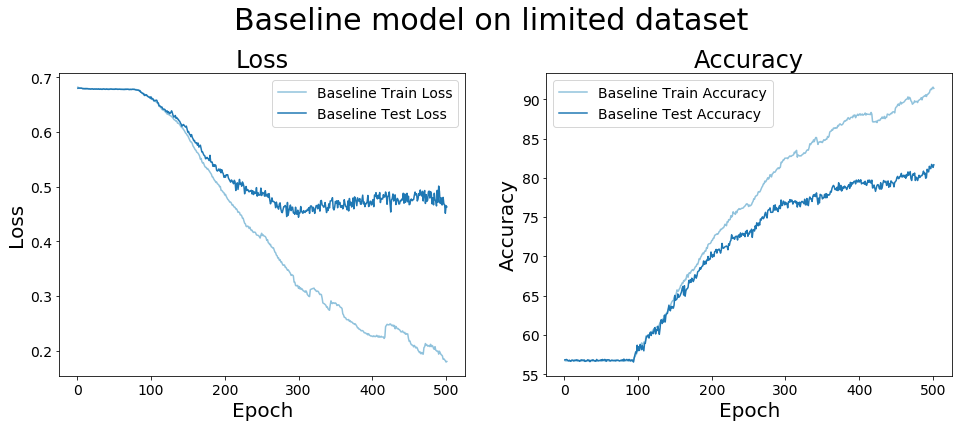

In [381]:
test_train_comparison_plot((limited_dataset_base_history, ), ('Baseline', ), ('Loss', 'Accuracy'), 'Baseline model on limited dataset', 
                            font_dict=FONT_DICT, title_font_dict=TITLE_FONT_DICT, colormap=DEFAULT_PAIRED_COLORMAP,
                           save_path='meta_learning/figures/baseline/limited_dataset.png')

## Full dataset, no anti-overfitting

In [300]:
full_dataset_base_history = api.run(FULL_DATASET_PATTERN.format(run_id='bckt4xx1')).history(pandas=True)

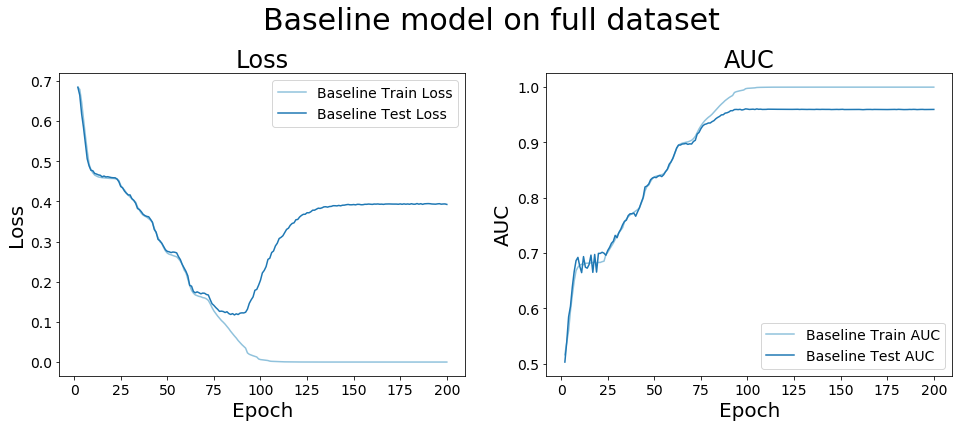

In [383]:
test_train_comparison_plot((full_dataset_base_history, ), ('Baseline', ), ('Loss', 'AUC'), 'Baseline model on full dataset', 
                            font_dict=FONT_DICT, title_font_dict=TITLE_FONT_DICT, colormap=DEFAULT_PAIRED_COLORMAP,
                           save_path='meta_learning/figures/baseline/full_dataset.png')

## With anti-overfitting measures

In [266]:
full_dataset_weight_decay_history = api.run(FULL_DATASET_PATTERN.format(run_id='elohyghn')).history(pandas=True)
full_dataset_dropout_history = api.run(FULL_DATASET_PATTERN.format(run_id='0de5ylqo')).history(pandas=True)

full_dataset_histories = (full_dataset_base_history, full_dataset_weight_decay_history, full_dataset_dropout_history)

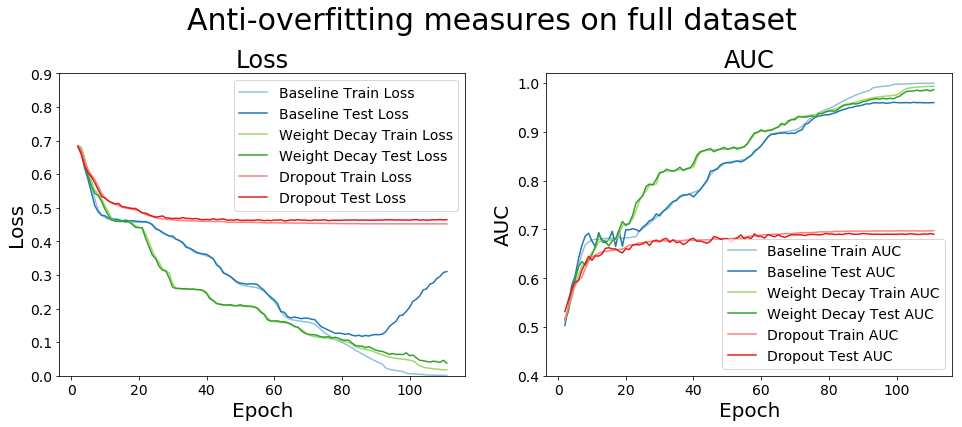

In [384]:
test_train_comparison_plot(full_dataset_histories, ('Baseline', 'Weight Decay', 'Dropout'), ('Loss', 'AUC'), 
                           'Anti-overfitting measures on full dataset', ylims=((0, 0.9), (0.4, 1.02)), compute_x_max=True,
                           font_dict=FONT_DICT, title_font_dict=TITLE_FONT_DICT, colormap=DEFAULT_PAIRED_COLORMAP,
                           save_path='meta_learning/figures/baseline/full_dataset_anti_overfitting.png')

## Plot the test accuracy and AUC for query-modulated models

In [385]:
NAMES = ['No query modulation'] + [f'Modulation level {d}' for d in range(1, 5)]

def multiple_comparison_plot(keys, titles, super_title, start_index=0, 
                             x_start=0, compute_x_max=False, font_dict=None, save_path=None):
    font = FONT_DICT.copy()
    if font_dict is not None:
        font.update(font_dict)
    font_dict = font
    
    plt.figure(figsize=(PER_PLOT_WIDTH * len(keys), 6))
    plt.subplots_adjust(top=0.825, hspace=0.25, wspace=0.2)
    plt.suptitle(super_title, fontsize=font_dict['fontsize'] * 1.5)
        
    x_max = None
    if compute_x_max:
        x_max = np.min([len(history[keys[0]]) for history in histories])
    
    for index, (key, title) in enumerate(zip(keys, titles)):
        ax = plt.subplot(1, len(keys), index + 1)
    
        for name, history in zip(NAMES[start_index:], histories[start_index:]):
            y_values = history[key][x_start:x_max]
            x_values = np.arange(len(y_values)) + x_start + 1
            ax.plot(x_values, y_values, label=name)

        legend_font_dict = font_dict.copy()
        legend_font_dict['fontsize'] = legend_font_dict['fontsize'] - 4
        ax.legend(loc='best', **legend_font_dict)
        ax.set_xlabel('Epoch', **font_dict)
        ax.set_ylabel(key, **font_dict)
        ax.set_title(title)
        
    save(save_path)        
    plt.show()



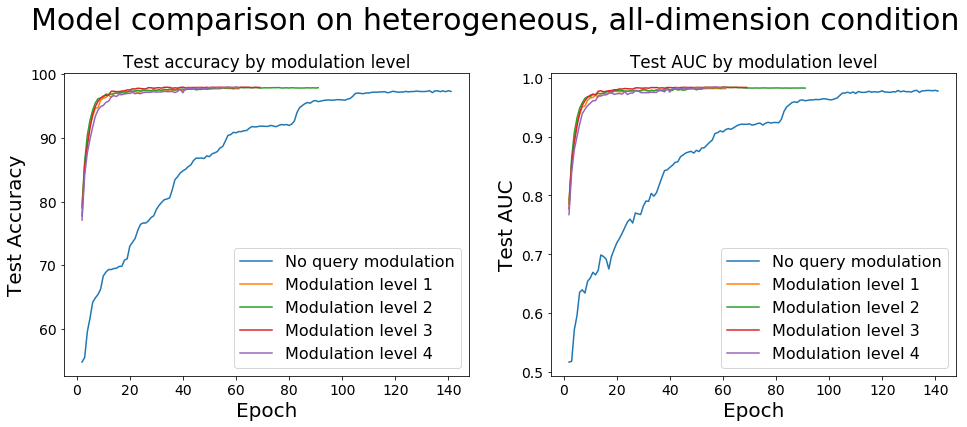

In [386]:
multiple_comparison_plot(('Test Accuracy', 'Test AUC'), 
                ('Test accuracy by modulation level', 'Test AUC by modulation level'),
                'Model comparison on heterogeneous, all-dimension condition',
                save_path='meta_learning/figures/query_mod_simultaneous/baseline_comparison.png')


Looks like these models all learn much faster than the baseline model, but don't actually peak at a higher accuracy. Let's focus only on them to see if we can learn much:

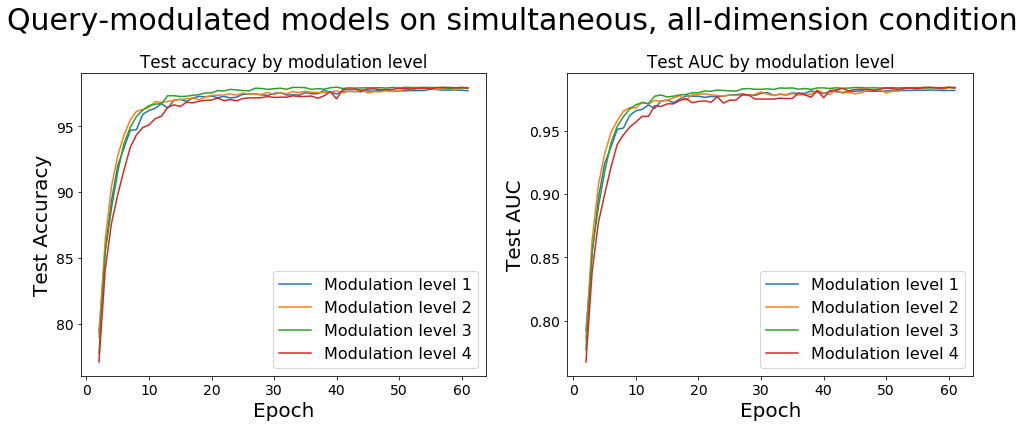

In [387]:
multiple_comparison_plot(('Test Accuracy', 'Test AUC'), 
                         ('Test accuracy by modulation level', 'Test AUC by modulation level'),
                         'Query-modulated models on simultaneous, all-dimension condition',
                         1, 0, True, save_path='meta_learning/figures/query_mod_simultaneous/query_mod_only.png')


Looks like the third modulation level is a little bit better, but let's zoom in a little bit:

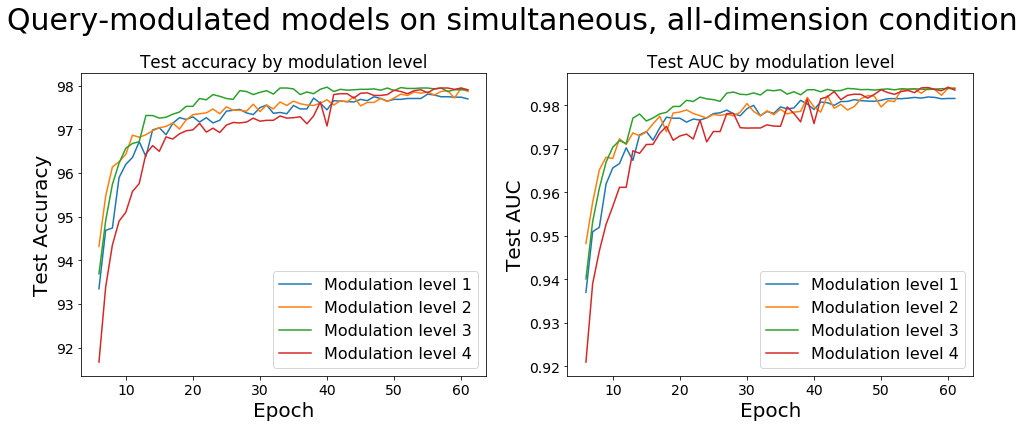

In [388]:
multiple_comparison_plot(('Test Accuracy', 'Test AUC'), 
                         ('Test accuracy by modulation level', 'Test AUC by modulation level'),
                         'Query-modulated models on simultaneous, all-dimension condition',
                         1, 5, True, save_path='meta_learning/figures/query_mod_simultaneous/query_mod_zoomed.png')


## Plotting accuracy by dimension, for each modulation level

In [210]:
QUERY_NAMES = ['blue', 'brown', 'cyan', 'gray', 'green', 'orange', 'pink',
               'purple', 'red', 'yellow', 'cone', 'cube', 'cylinder',
               'dodecahedron', 'ellipsoid', 'octahedron', 'pyramid', 'rectangle',
               'sphere', 'torus', 'chain_mail', 'marble', 'maze', 'metal',
               'metal_weave', 'polka', 'rubber', 'rug', 'tiles', 'wood_plank']
DIMENSION_NAMES = ['color', 'shape', 'texture']
KEY_TEMPLATE = 'Test Per-Query Accuracy (dict).{task_id}'

COLORS = dict(gray=(0.3411764705882353, 0.3411764705882353, 0.3411764705882353),
              red=(0.6784313725490196, 0.13725490196078433, 0.13725490196078433),
              blue=(0.16470588235294117, 0.29411764705882354, 0.8431372549019608),
              green=(0.11372549019607843, 0.4117647058823529, 0.0784313725490196),
              brown=(0.5058823529411764, 0.2901960784313726, 0.09803921568627451),
              purple=(0.5058823529411764, 0.14901960784313725, 0.7529411764705882),
              cyan=(0.1607843137254902, 0.8156862745098039, 0.8156862745098039),
              yellow=(1.0, 0.9333333333333333, 0.2),
              orange=(1.0, 0.5725490196078431, 0.2),
              pink=(1.0, 0.803921568627451, 0.9529411764705882))

In [391]:
NROWS = 5
NCOLS = 3

PER_COL_WIDTH = 8
PER_ROW_HEIGHT = 6

def plot_accuracy_by_dimension(histories, font_dict=None, ylim=None,
                               x_start=0, compute_x_max=False, colors=None, save_path=None):
    font = FONT_DICT.copy()
    if font_dict is not None:
        font.update(font_dict)
    font_dict = font
    
    plt.figure(figsize=(NCOLS * PER_COL_WIDTH, NROWS * PER_ROW_HEIGHT))
    plt.subplots_adjust(top=0.95, hspace=0.2, wspace=0.15)
    
    plt.suptitle('Accuracy per dimension by modulation level', fontsize=font_dict['fontsize'] * 1.5)
    
    x_max = None
    if compute_x_max:
        x_max = np.min([history.shape[0] for history in histories])
        
    for model_index, history in enumerate(histories):
        for dimension_index, dimension_name in enumerate(DIMENSION_NAMES):
            ax = plt.subplot(NROWS, NCOLS, model_index * NCOLS + dimension_index + 1)

            title = None
            if model_index == 0:
                title = dimension_name.capitalize()
                
            x_label = None
            if model_index == NROWS - 1:
                x_label = 'Epoch'
                
            y_label = None
            y_label_right = False
            if dimension_index == 0:
                y_label = 'Test Accuracy'
            elif dimension_index == 2:
                y_label_right = True
                if model_index == 0:
                    y_label = f'No query\nmodulation'
                else:
                    y_label = f'Query modulation\nat conv-{model_index}'
            
            # Use x_max only for the non-query-modulated models
            model_x_max = x_max
            if model_index == 0:
                model_x_max = None
                
            single_model_single_dimension_plot(ax, history,
                                               10 * dimension_index, 
                                               10 * (dimension_index + 1), 
                                               x_start, model_x_max, ylim, title, x_label, y_label, 
                                               font_dict, colors, y_label_right)
    
    save(save_path)
    
    plt.show()
    
    
def single_model_single_dimension_plot(ax, history,
                                       start_task, end_task, x_start=0, x_max=None, ylim=None,
                                        title=None, x_label=None, y_label=None,
                                          font_dict=None, colors=None, y_label_right=False):
    font = FONT_DICT.copy()
    if font_dict is not None:
        font.update(font_dict)
    font_dict = font
    
    sample_y_values = history[KEY_TEMPLATE.format(task_id=start_task)][x_start:x_max]
    x_values = np.arange(len(sample_y_values)) + x_start
    
    for index, task_id in enumerate(range(start_task, end_task)):
        color = None
        if colors is not None:
            if isinstance (colors, dict):
                color = colors[QUERY_NAMES[index % 10]]
            else:
                color = colors[index / 10]
        
        ax.plot(x_values, history[KEY_TEMPLATE.format(task_id=task_id)][x_start:x_max] * 100,
                label=QUERY_NAMES[task_id], color=color, alpha=0.8)
    
    if ylim is not None:
        ax.set_ylim(ylim)
    
    legend_fontsize = font_dict['fontsize'] - 8
    ax.legend(loc='lower right', fontsize=legend_fontsize)
    if x_label is not None:
        ax.set_xlabel(x_label, **font_dict)
    if y_label is not None:
        ax.set_ylabel(y_label, **font_dict)
    if y_label_right:    
        ax.yaxis.set_label_position("right")
    if title is not None:
        ax.set_title(title, **font_dict)

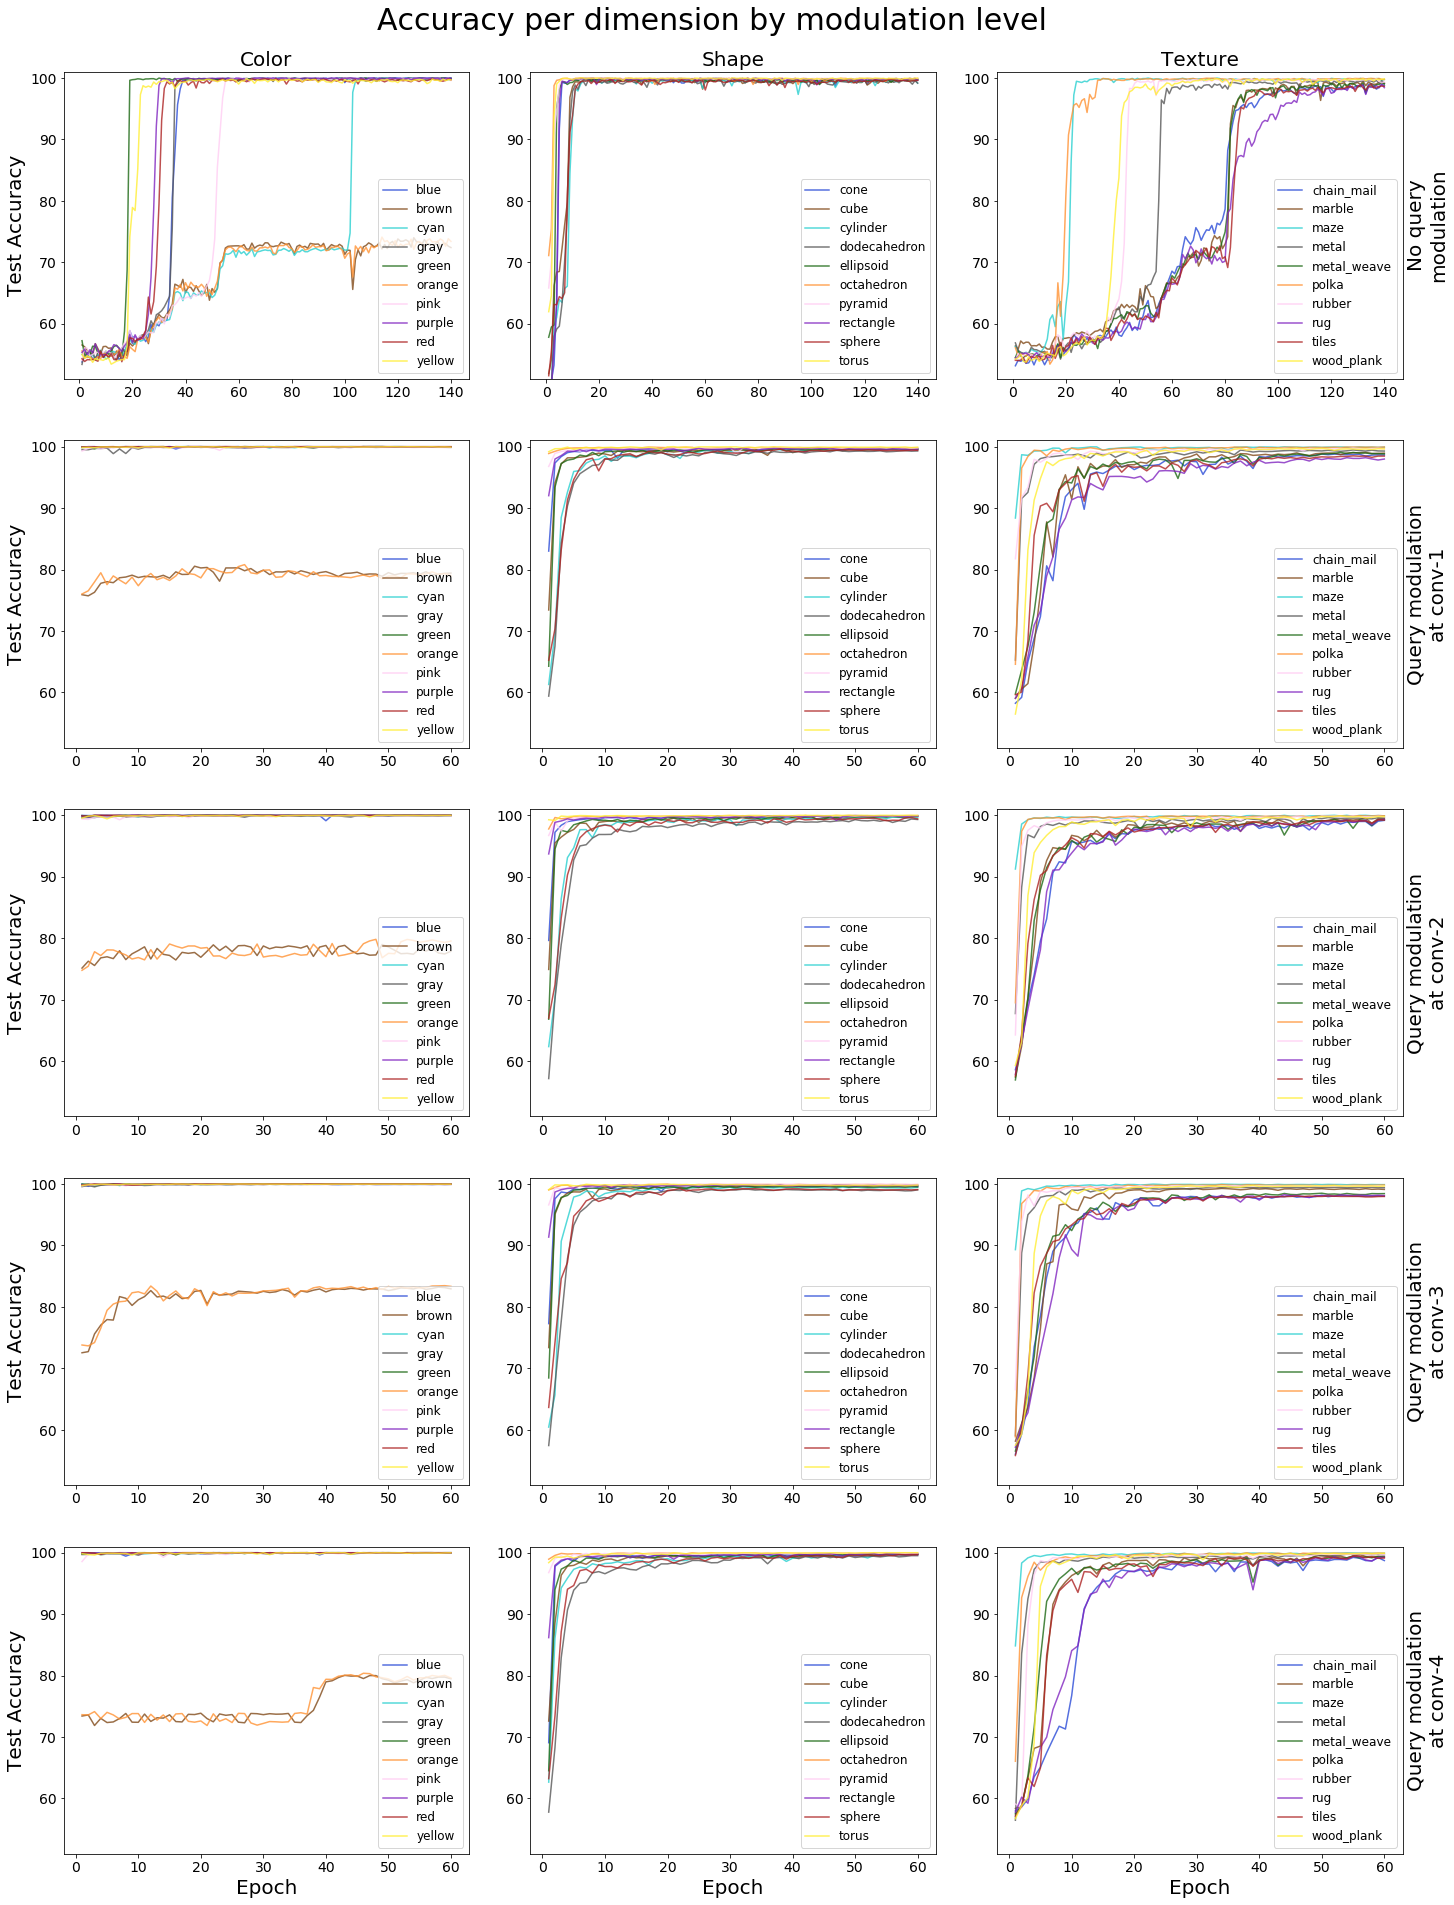

In [393]:
ylim = (51, 101)
plot_accuracy_by_dimension(histories, compute_x_max=True, ylim=ylim, colors=COLORS,
                           save_path='meta_learning/figures/query_mod_simultaneous/query_mod_by_dimension.png')